# 저상버스 혼잡도 EDA

**목표**: 606번, 420번 노선의 승하차 데이터로부터 혼잡도 패턴을 탐색한다.
- 평일 vs 주말 vs 공휴일 패턴
- 출퇴근 피크타임 분석
- 시간대별 혼잡도 분포
- 날씨 영향 분석
- 혼잡도 지수(0~1) 산출 방안 검토

In [43]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path

# 한글 폰트 설정
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid', font=font_prop.get_name())

DATA_DIR = Path('../data')

## 1. 데이터 로드

In [44]:
# 일별 승하차 데이터
daily = pd.read_csv(DATA_DIR / 'filtered/daily_boarding_606_420.csv', encoding='utf-8-sig')
daily['사용일자'] = pd.to_datetime(daily['사용일자'], format='%Y%m%d')
print(f"일별 데이터: {daily.shape}")
print(f"기간: {daily['사용일자'].min()} ~ {daily['사용일자'].max()}")
print(f"노선: {daily['노선번호'].unique()}")
daily.head()

일별 데이터: (39002, 9)
기간: 2025-08-01 00:00:00 ~ 2026-01-31 00:00:00
노선: [606 420]


,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자
0,2025-08-01,606,606번(부천상동~종로1가),100000018,01113,사직단.어린이도서관(00067),101,54,20250804
1,2025-08-01,606,606번(부천상동~종로1가),100000019,01114,경복궁역1번출구(00066),472,76,20250804
2,2025-08-01,606,606번(부천상동~종로1가),100000022,01117,경복궁(00061),65,107,20250804
3,2025-08-01,606,606번(부천상동~종로1가),100000023,01118,광화문역2번출구.KT광화문지사(00065),276,31,20250804
4,2025-08-01,606,606번(부천상동~종로1가),100000032,01127,서울경찰청.경복궁역(00060),35,290,20250804


In [45]:
# 시간대별 승하차 데이터 (월별 집계)
hourly = pd.read_csv(DATA_DIR / 'filtered/hourly_boarding_606_420.csv', encoding='utf-8-sig')
print(f"시간대별 데이터: {hourly.shape}")
print(f"기간(월): {sorted(hourly['사용년월'].unique())}")
hourly.head(3)

시간대별 데이터: (1366, 57)
기간(월): [202508, 202509, 202510, 202511, 202512, 202601]


,사용년월,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,00시승차총승객수,00시하차총승객수,1시승차총승객수,1시하차총승객수,...,20시하차총승객수,21시승차총승객수,21시하차총승객수,22시승차총승객수,22시하차총승객수,23시승차총승객수,23시하차총승객수,교통수단타입코드,교통수단타입명,등록일자
0,202508,606,606번(부천상동~종로1가),100000018,01113,사직단.어린이도서관(00067),16,10,0,0,...,53,152,54,144,51,97,41,10,서울간선버스,20250903
1,202508,606,606번(부천상동~종로1가),100000019,01114,경복궁역1번출구(00066),122,4,0,0,...,88,875,74,689,43,509,27,10,서울간선버스,20250903
2,202508,606,606번(부천상동~종로1가),100000022,01117,경복궁(00061),3,0,0,0,...,48,75,40,51,25,16,31,10,서울간선버스,20250903


In [46]:
# 공휴일 데이터
holidays = pd.read_csv(DATA_DIR / 'raw/holidays.csv')
holidays['날짜'] = pd.to_datetime(holidays['날짜'])
holiday_dates = set(holidays['날짜'])
print(f"공휴일 수: {len(holidays)}")
holidays

공휴일 수: 9


,날짜,공휴일명,비고
0,2025-08-15,광복절,NaN
1,2025-10-03,개천절,NaN
2,2025-10-05,추석연휴,NaN
3,2025-10-06,추석,NaN
4,2025-10-07,추석연휴,NaN
5,2025-10-08,대체공휴일,추석
6,2025-10-09,한글날,NaN
7,2025-12-25,크리스마스,NaN
8,2026-01-01,신정,NaN


In [47]:
# 날씨 데이터
weather = pd.read_csv(DATA_DIR / 'raw/weather_hourly.csv', encoding='cp949')
weather.columns = ['지점', '지점명', '일시', '기온', '기온QC', '강수량', '강수량QC', '풍속', '풍속QC', '적설', '3시간신적설']
weather['일시'] = pd.to_datetime(weather['일시'])
weather['날짜'] = weather['일시'].dt.date
weather['시간'] = weather['일시'].dt.hour
weather['강수량'] = pd.to_numeric(weather['강수량'], errors='coerce').fillna(0)
weather['기온'] = pd.to_numeric(weather['기온'], errors='coerce')
weather['풍속'] = pd.to_numeric(weather['풍속'], errors='coerce')
print(f"날씨 데이터: {weather.shape}")
weather[['일시', '기온', '강수량', '풍속']].head()

날씨 데이터: (4416, 13)


,일시,기온,강수량,풍속
0,2025-08-01 00:00:00,29.3,0.0,1.6
1,2025-08-01 01:00:00,29.0,0.0,1.8
2,2025-08-01 02:00:00,28.8,0.0,1.4
3,2025-08-01 03:00:00,28.6,0.0,1.3
4,2025-08-01 04:00:00,28.2,0.0,1.9


## 2. 날짜 기반 피처 엔지니어링

기존 `사용일자`로부터 다음을 추출할 수 있다:
- 요일 (0=월 ~ 6=일)
- 주말 여부
- 공휴일 여부
- 월
- 출퇴근 시간대 (시간대별 데이터에서)

In [48]:
daily['요일'] = daily['사용일자'].dt.dayofweek          # 0=월 ~ 6=일
daily['요일명'] = daily['사용일자'].dt.day_name()
daily['주말'] = daily['요일'].isin([5, 6]).astype(int)
daily['공휴일'] = daily['사용일자'].isin(holiday_dates).astype(int)
daily['휴일'] = ((daily['주말'] == 1) | (daily['공휴일'] == 1)).astype(int)  # 주말 or 공휴일
daily['월'] = daily['사용일자'].dt.month

print("피처 분포:")
print(f"  평일: {(daily['휴일']==0).sum():,}건")
print(f"  주말: {((daily['주말']==1) & (daily['공휴일']==0)).sum():,}건")
print(f"  공휴일(평일): {((daily['주말']==0) & (daily['공휴일']==1)).sum():,}건")
daily[['사용일자', '노선번호', '역명', '승차총승객수', '요일명', '주말', '공휴일', '휴일']].head(10)

피처 분포:
  평일: 25,937건
  주말: 11,144건
  공휴일(평일): 1,707건


,사용일자,노선번호,역명,승차총승객수,요일명,주말,공휴일,휴일
0,2025-08-01,606,사직단.어린이도서관(00067),101,Friday,0,0,0
1,2025-08-01,606,경복궁역1번출구(00066),472,Friday,0,0,0
2,2025-08-01,606,경복궁(00061),65,Friday,0,0,0
3,2025-08-01,606,광화문역2번출구.KT광화문지사(00065),276,Friday,0,0,0
4,2025-08-01,606,서울경찰청.경복궁역(00060),35,Friday,0,0,0
5,2025-08-01,606,사직단(00059),42,Friday,0,0,0
6,2025-08-01,606,조계사.종로경찰서(00063),154,Friday,0,0,0
7,2025-08-01,606,안국동사거리(00062),106,Friday,0,0,0
8,2025-08-01,606,종로1가(00064),251,Friday,0,0,0
9,2025-08-01,606,연희104고지앞.구성산회관(00053),81,Friday,0,0,0


## 3. 일별 혼잡도 패턴 분석

### 3-1. 노선별 일 평균 승차 인원 추이

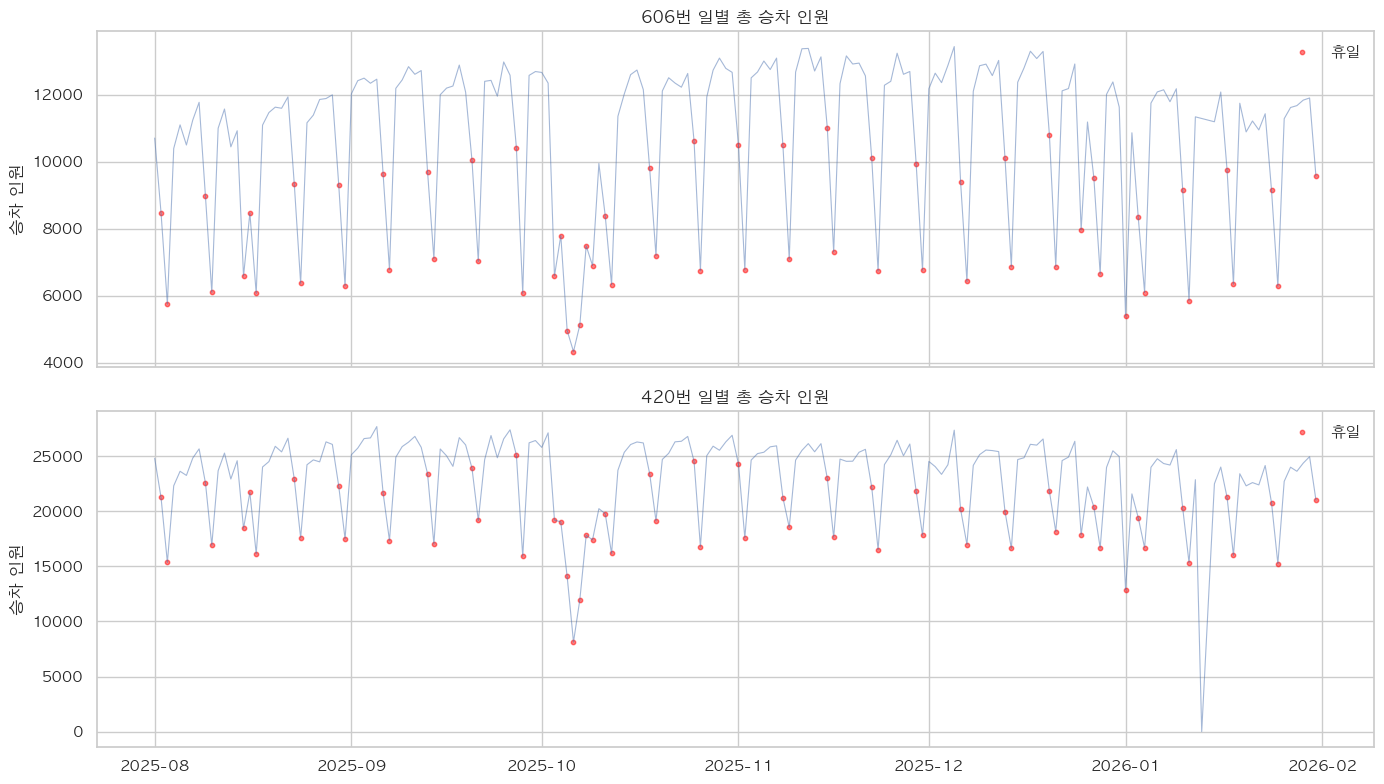

In [49]:
# 노선별 날짜별 전체 승차 합계
daily_total = daily.groupby(['사용일자', '노선번호']).agg(
    승차합계=('승차총승객수', 'sum'),
    하차합계=('하차총승객수', 'sum'),
    정류장수=('역명', 'nunique'),
    휴일=('휴일', 'first'),
    요일=('요일', 'first'),
    요일명=('요일명', 'first')
).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
for i, route in enumerate([606, 420]):
    df = daily_total[daily_total['노선번호'] == route]
    ax = axes[i]
    ax.plot(df['사용일자'], df['승차합계'], alpha=0.5, linewidth=0.8)
    # 주말/공휴일 표시
    holiday_df = df[df['휴일'] == 1]
    ax.scatter(holiday_df['사용일자'], holiday_df['승차합계'], color='red', s=10, alpha=0.5, label='휴일')
    ax.set_title(f'{route}번 일별 총 승차 인원')
    ax.set_ylabel('승차 인원')
    ax.legend()
plt.tight_layout()
plt.show()

### 3-2. 평일 vs 주말 vs 공휴일 비교

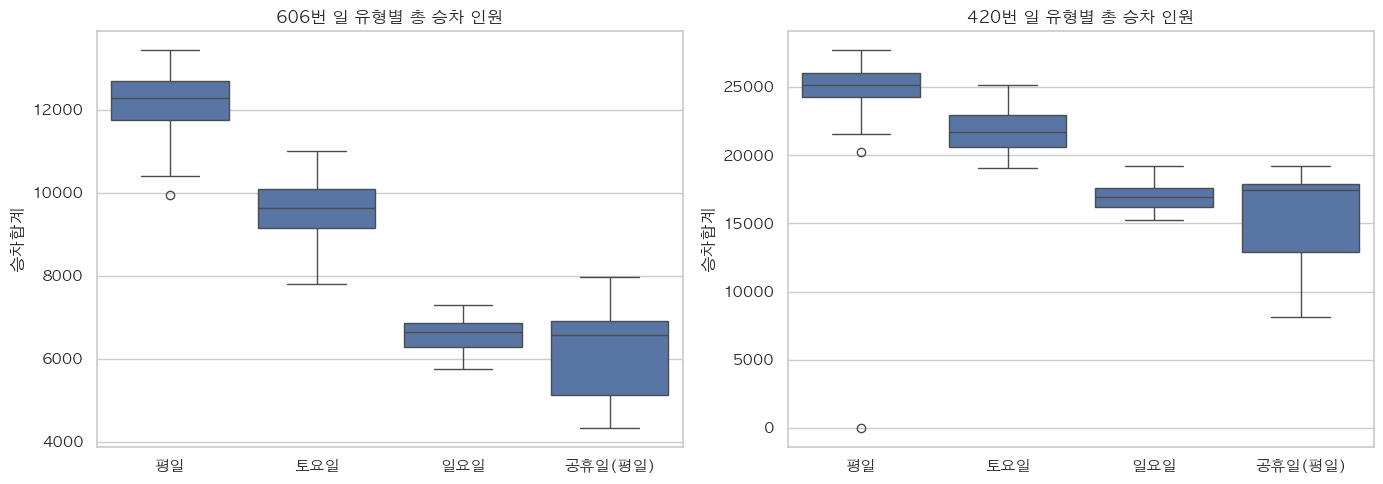

mean   median     std  count
노선번호 일유형                                     
420  공휴일(평일)  15314.0  17406.0  3749.0      9
     일요일      16996.0  16921.0  1077.0     25
     토요일      21826.0  21708.0  1618.0     27
     평일       24839.0  25132.0  2621.0    122
606  공휴일(평일)   6153.0   6588.0  1244.0      9
     일요일       6559.0   6650.0   434.0     25
     토요일       9588.0   9633.0   819.0     27
     평일       12175.0  12286.0   725.0    121

In [50]:
# 일 유형 분류
def classify_day(row):
    if row['공휴일'] == 1 and row['주말'] == 0:
        return '공휴일(평일)'
    elif row['요일'] == 5:
        return '토요일'
    elif row['요일'] == 6:
        return '일요일'
    else:
        return '평일'

daily['일유형'] = daily.apply(classify_day, axis=1)
daily_total['일유형'] = daily_total.apply(
    lambda r: classify_day({'공휴일': 0, '주말': 1 if r['요일'] in [5,6] else 0, '요일': r['요일']})
    if r['사용일자'] not in holiday_dates else '공휴일(평일)',
    axis=1
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
order = ['평일', '토요일', '일요일', '공휴일(평일)']
for i, route in enumerate([606, 420]):
    df = daily_total[daily_total['노선번호'] == route]
    sns.boxplot(data=df, x='일유형', y='승차합계', order=order, ax=axes[i])
    axes[i].set_title(f'{route}번 일 유형별 총 승차 인원')
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()

# 수치 요약
summary = daily_total.groupby(['노선번호', '일유형'])['승차합계'].agg(['mean', 'median', 'std', 'count']).round(0)
summary

### 3-3. 요일별 평균 승차 인원

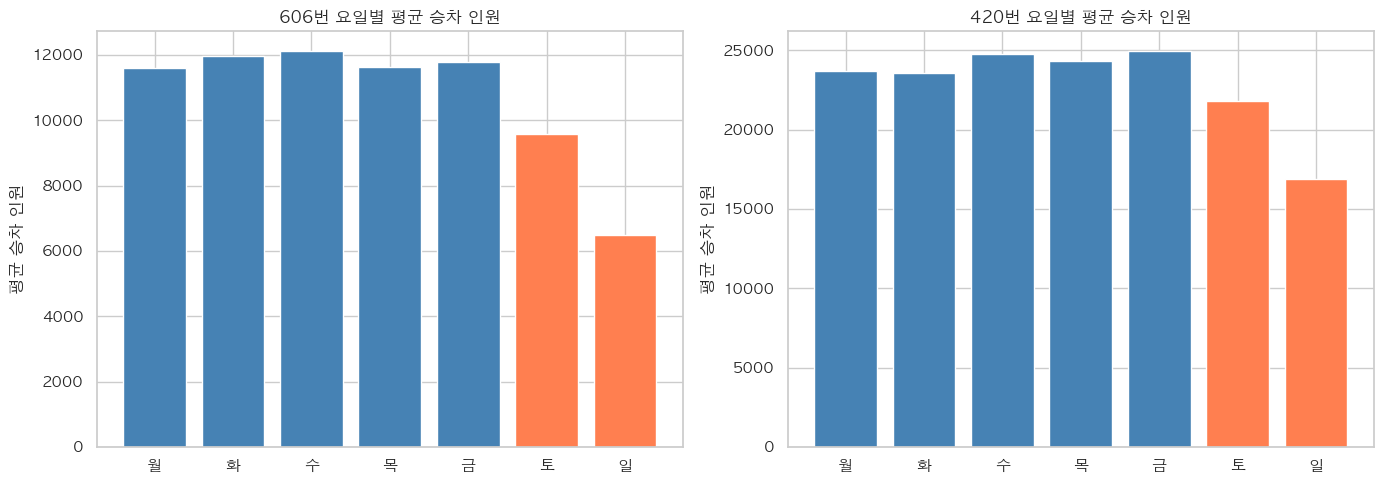

In [51]:
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_kr = {'Monday': '월', 'Tuesday': '화', 'Wednesday': '수', 'Thursday': '목',
           'Friday': '금', 'Saturday': '토', 'Sunday': '일'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, route in enumerate([606, 420]):
    df = daily_total[daily_total['노선번호'] == route]
    dow_avg = df.groupby('요일명')['승차합계'].mean().reindex(dow_order)
    axes[i].bar(range(7), dow_avg.values, color=['steelblue']*5 + ['coral']*2)
    axes[i].set_xticks(range(7))
    axes[i].set_xticklabels([dow_kr[d] for d in dow_order])
    axes[i].set_title(f'{route}번 요일별 평균 승차 인원')
    axes[i].set_ylabel('평균 승차 인원')
plt.tight_layout()
plt.show()

## 4. 시간대별 혼잡도 패턴 (출퇴근 피크타임)

시간대별 데이터(`hourly_boarding`)는 **월별로 집계**되어 있다.  
→ 개별 날짜의 시간대 패턴은 알 수 없지만, **월별 평균 시간대 분포**는 파악 가능하다.

In [52]:
# 시간대별 데이터를 long format으로 변환
boarding_cols = [f'{h}시승차총승객수' for h in range(24)]
alighting_cols = [f'{h}시하차총승객수' for h in range(24)]

# 0시 컬럼은 '00시승차총승객수' 형태
boarding_cols[0] = '00시승차총승객수'
alighting_cols[0] = '00시하차총승객수'

def melt_hourly(df, route):
    """월별 시간대 데이터를 long format으로 변환"""
    route_df = df[df['노선번호'] == route].copy()
    records = []
    for _, row in route_df.iterrows():
        for h in range(24):
            b_col = f'{h}시승차총승객수' if h > 0 else '00시승차총승객수'
            a_col = f'{h}시하차총승객수' if h > 0 else '00시하차총승객수'
            records.append({
                '사용년월': row['사용년월'],
                '역명': row['역명'],
                '정류장ID': row['표준버스정류장ID'],
                '시간': h,
                '승차': row[b_col],
                '하차': row[a_col]
            })
    return pd.DataFrame(records)

hourly_606 = melt_hourly(hourly, 606)
hourly_420 = melt_hourly(hourly, 420)
print(f"606번 시간대별: {hourly_606.shape}")
print(f"420번 시간대별: {hourly_420.shape}")

606번 시간대별: (18048, 6)
420번 시간대별: (14736, 6)


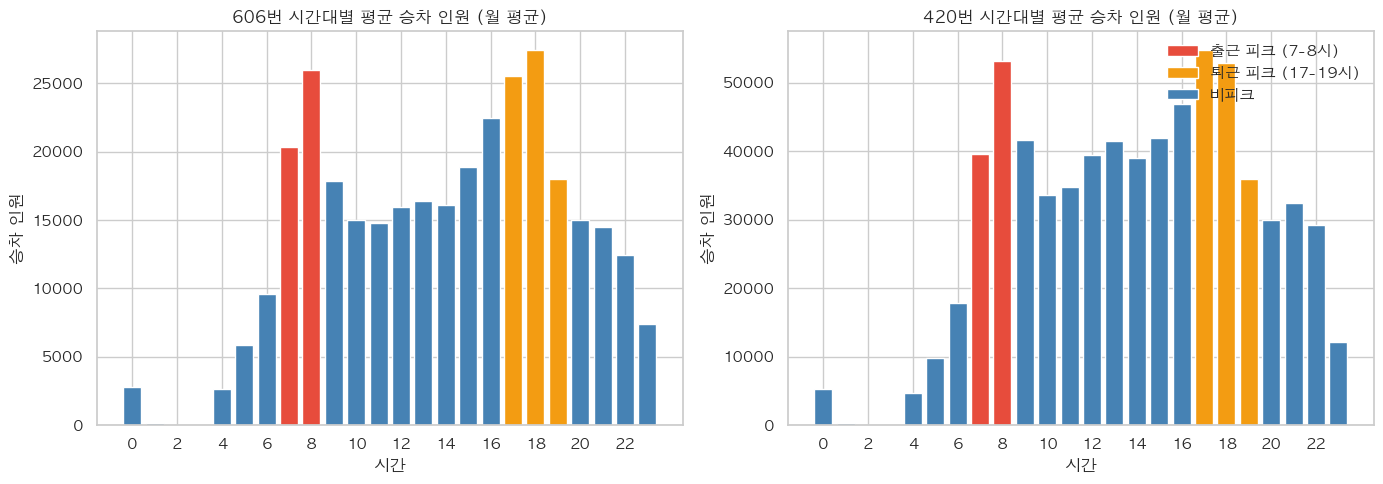

In [53]:
# 노선별 전체 시간대 승차 패턴 (전 정류장 합산, 월 평균)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (name, df) in enumerate([('606', hourly_606), ('420', hourly_420)]):
    hourly_agg = df.groupby(['사용년월', '시간'])['승차'].sum().reset_index()
    hourly_avg = hourly_agg.groupby('시간')['승차'].mean()
    
    colors = ['#e74c3c' if h in [7, 8] else '#f39c12' if h in [17, 18, 19] else 'steelblue' for h in range(24)]
    axes[i].bar(range(24), hourly_avg.values, color=colors)
    axes[i].set_title(f'{name}번 시간대별 평균 승차 인원 (월 평균)')
    axes[i].set_xlabel('시간')
    axes[i].set_ylabel('승차 인원')
    axes[i].set_xticks(range(0, 24, 2))

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='출근 피크 (7-8시)'),
    Patch(facecolor='#f39c12', label='퇴근 피크 (17-19시)'),
    Patch(facecolor='steelblue', label='비피크')
]
axes[1].legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

In [54]:
# 피크 vs 비피크 승차 비율
for name, df in [('606', hourly_606), ('420', hourly_420)]:
    total = df['승차'].sum()
    am_peak = df[df['시간'].isin([7, 8])]['승차'].sum()
    pm_peak = df[df['시간'].isin([17, 18, 19])]['승차'].sum()
    print(f"\n{name}번:")
    print(f"  출근 피크(7-8시): {am_peak:,} ({am_peak/total*100:.1f}%)")
    print(f"  퇴근 피크(17-19시): {pm_peak:,} ({pm_peak/total*100:.1f}%)")
    print(f"  피크 합계: {am_peak+pm_peak:,} ({(am_peak+pm_peak)/total*100:.1f}%)")


606번:
  출근 피크(7-8시): 277,666 (14.2%)
  퇴근 피크(17-19시): 425,950 (21.8%)
  피크 합계: 703,616 (36.1%)

420번:
  출근 피크(7-8시): 556,999 (13.3%)
  퇴근 피크(17-19시): 862,153 (20.6%)
  피크 합계: 1,419,152 (33.9%)


## 5. 정류장별 혼잡도 지수 산출

**혼잡도 지수** = `승차총승객수 / 해당 정류장 최대 승차 인원`  
→ 0~1 사이의 연속값으로 정규화

In [55]:
# 정류장별 최대 승차 인원 (노선별)
stop_max = daily.groupby(['노선번호', '역명'])['승차총승객수'].max().reset_index()
stop_max.columns = ['노선번호', '역명', '최대승차']

daily = daily.merge(stop_max, on=['노선번호', '역명'], how='left')
daily['혼잡도'] = daily['승차총승객수'] / daily['최대승차']
daily['혼잡도'] = daily['혼잡도'].clip(0, 1)  # 안전장치

print("혼잡도 분포:")
daily['혼잡도'].describe()

혼잡도 분포:


count    39002.000000
mean         0.605918
std          0.223411
min          0.000000
25%          0.464587
50%          0.651705
75%          0.774124
max          1.000000
Name: 혼잡도, dtype: float64

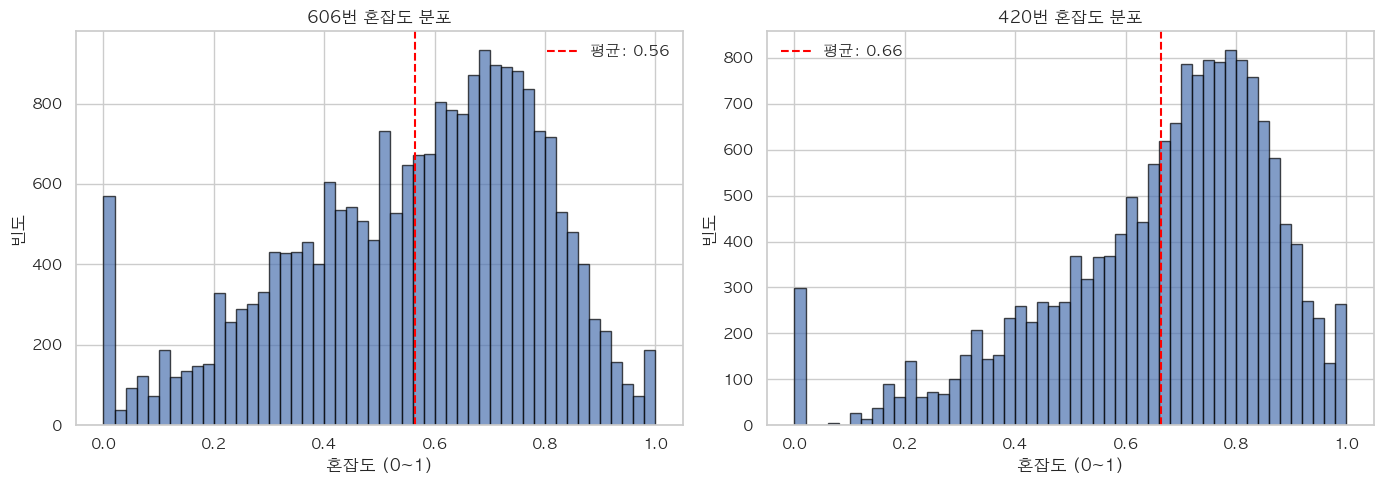

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, route in enumerate([606, 420]):
    df = daily[daily['노선번호'] == route]
    axes[i].hist(df['혼잡도'], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{route}번 혼잡도 분포')
    axes[i].set_xlabel('혼잡도 (0~1)')
    axes[i].set_ylabel('빈도')
    axes[i].axvline(df['혼잡도'].mean(), color='red', linestyle='--', label=f"평균: {df['혼잡도'].mean():.2f}")
    axes[i].legend()
plt.tight_layout()
plt.show()

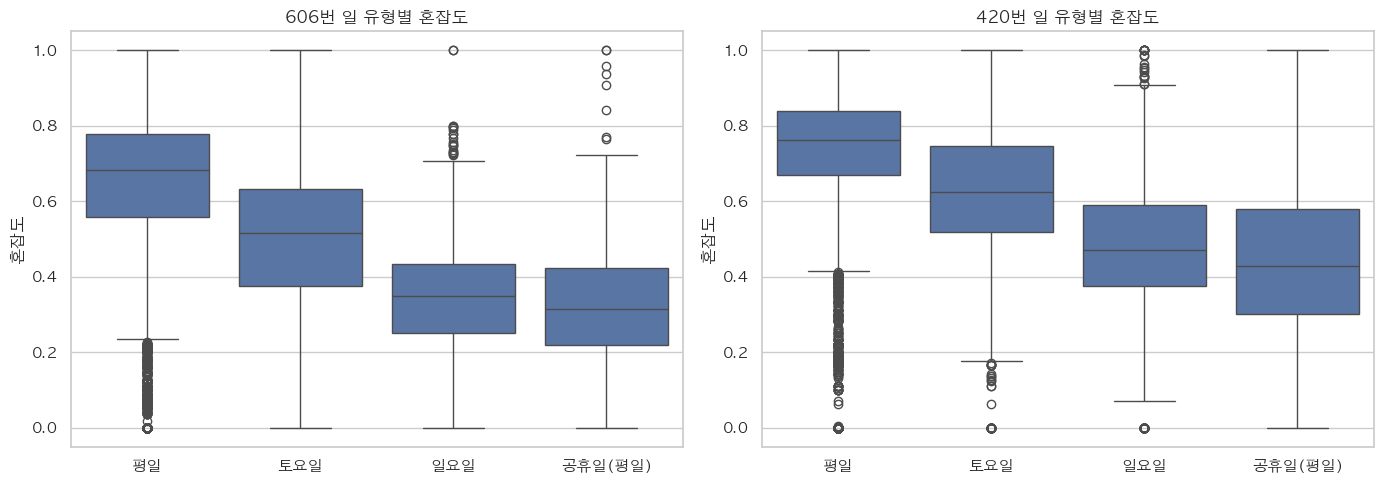

In [57]:
# 평일 vs 휴일 혼잡도 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, route in enumerate([606, 420]):
    df = daily[daily['노선번호'] == route]
    sns.boxplot(data=df, x='일유형', y='혼잡도', order=['평일', '토요일', '일요일', '공휴일(평일)'], ax=axes[i])
    axes[i].set_title(f'{route}번 일 유형별 혼잡도')
    axes[i].set_xlabel('')
plt.tight_layout()
plt.show()

## 6. 날씨 영향 분석

In [58]:
# 일별 날씨 요약 (일 평균 기온, 일 강수량 합계, 일 평균 풍속)
weather_daily = weather.groupby('날짜').agg(
    평균기온=('기온', 'mean'),
    강수량합계=('강수량', 'sum'),
    평균풍속=('풍속', 'mean')
).reset_index()
weather_daily['날짜'] = pd.to_datetime(weather_daily['날짜'])
weather_daily['비온날'] = (weather_daily['강수량합계'] > 0).astype(int)

# daily에 날씨 병합
daily = daily.merge(weather_daily, left_on='사용일자', right_on='날짜', how='left')

print(f"비 온 날 비율: {weather_daily['비온날'].mean()*100:.1f}%")
weather_daily.describe().round(1)

비 온 날 비율: 34.2%


,날짜,평균기온,강수량합계,평균풍속,비온날
count,184,184.0,184.0,184.0,184.0
mean,2025-10-31 12:00:00,12.4,5.0,2.2,0.3
min,2025-08-01 00:00:00,-9.5,0.0,1.3,0.0
25%,2025-09-15 18:00:00,2.5,0.0,1.8,0.0
50%,2025-10-31 12:00:00,12.4,0.0,2.2,0.0
75%,2025-12-16 06:00:00,23.4,0.6,2.6,1.0
max,2026-01-31 00:00:00,31.1,126.7,5.0,1.0
std,NaN,11.9,14.4,0.6,0.5


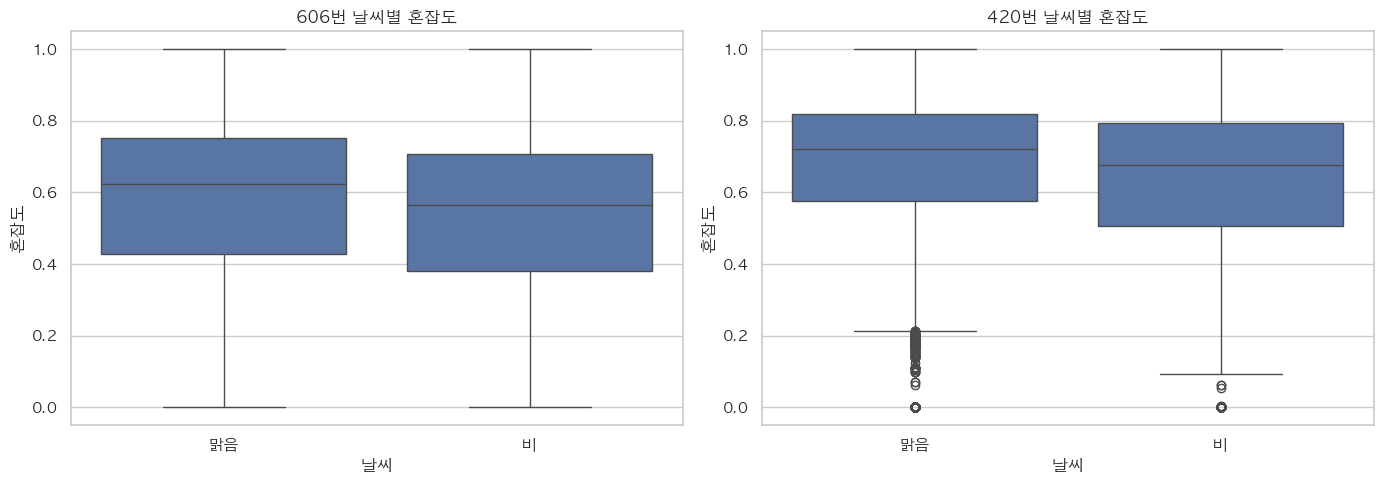


606번:
      mean  median  count
비온날                      
0    0.579   0.623  14991
1    0.535   0.565   7750

420번:
      mean  median  count
비온날                      
0    0.678   0.722  10724
1    0.636   0.676   5537


In [59]:
# 비 오는 날 vs 안 오는 날 혼잡도
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, route in enumerate([606, 420]):
    df = daily[(daily['노선번호'] == route) & (daily['비온날'].notna())]
    rain_labels = {0: '맑음', 1: '비'}
    df_plot = df.copy()
    df_plot['날씨'] = df_plot['비온날'].map(rain_labels)
    sns.boxplot(data=df_plot, x='날씨', y='혼잡도', ax=axes[i])
    axes[i].set_title(f'{route}번 날씨별 혼잡도')
plt.tight_layout()
plt.show()

# 수치 비교
for route in [606, 420]:
    df = daily[(daily['노선번호'] == route) & (daily['비온날'].notna())]
    print(f"\n{route}번:")
    print(df.groupby('비온날')['혼잡도'].agg(['mean', 'median', 'count']).round(3))

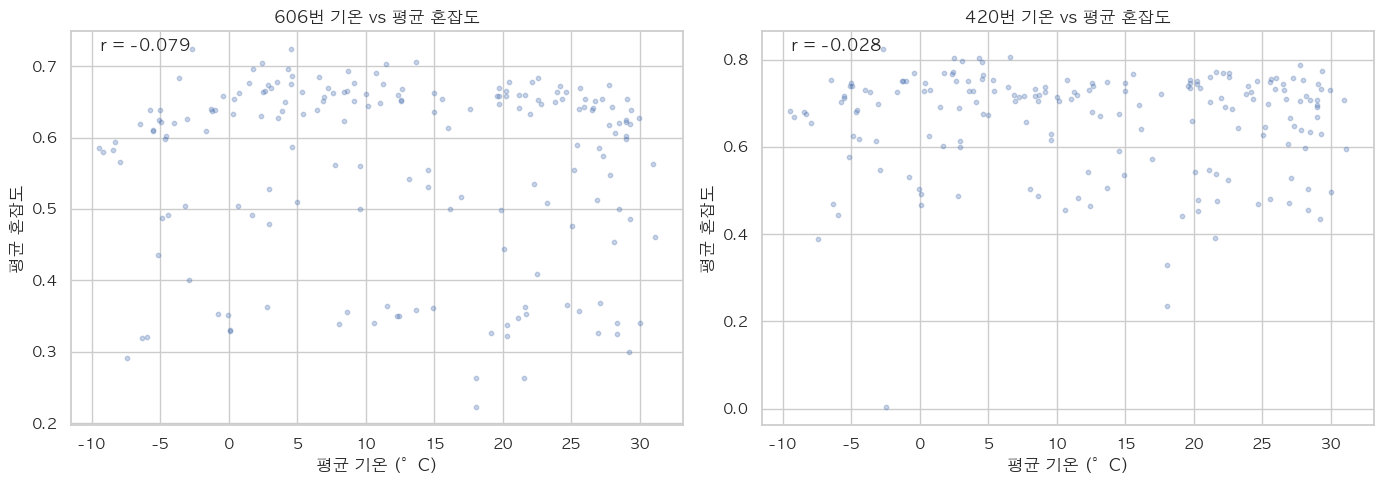

In [60]:
# 기온 vs 혼잡도 상관관계
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, route in enumerate([606, 420]):
    df = daily[(daily['노선번호'] == route) & (daily['평균기온'].notna())]
    # 정류장별 일 평균 혼잡도로 집계
    day_avg = df.groupby('사용일자').agg(혼잡도=('혼잡도', 'mean'), 기온=('평균기온', 'first')).reset_index()
    axes[i].scatter(day_avg['기온'], day_avg['혼잡도'], alpha=0.3, s=10)
    axes[i].set_title(f'{route}번 기온 vs 평균 혼잡도')
    axes[i].set_xlabel('평균 기온 (°C)')
    axes[i].set_ylabel('평균 혼잡도')
    corr = day_avg['기온'].corr(day_avg['혼잡도'])
    axes[i].annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.tight_layout()
plt.show()

## 7. 주요 정류장별 혼잡도 히트맵

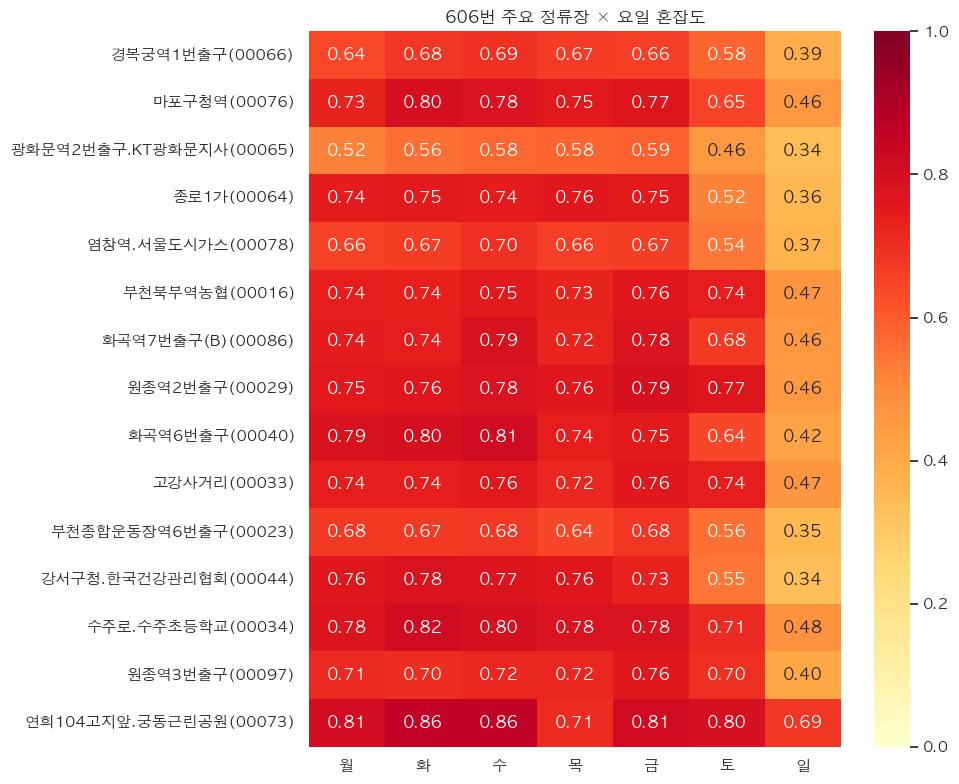

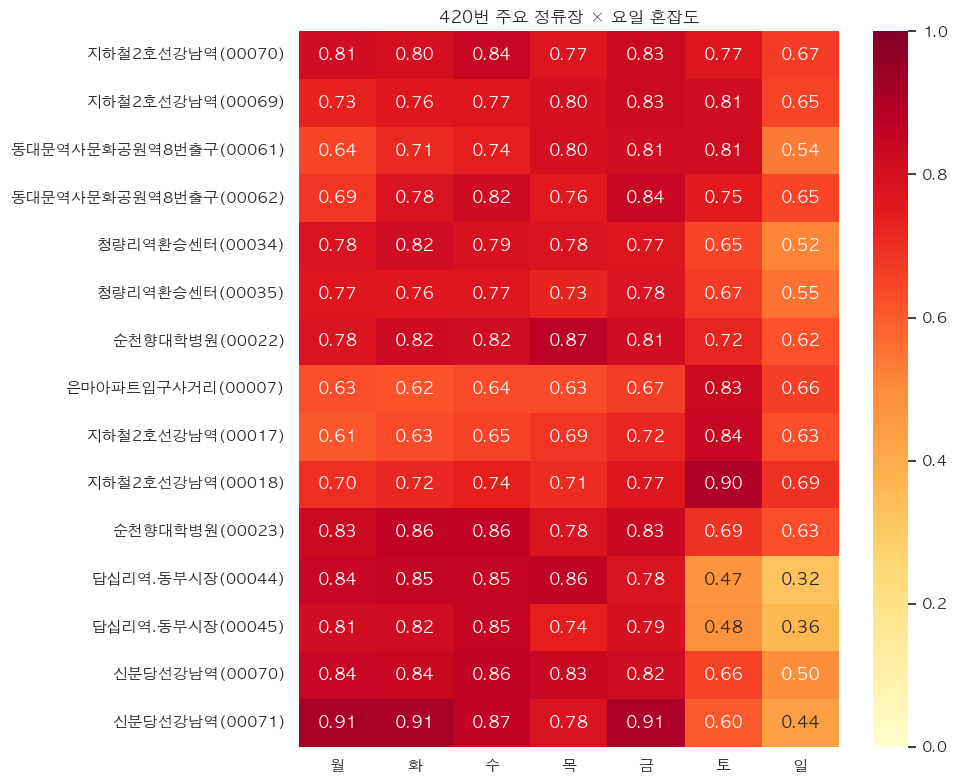

In [61]:
# 606번 상위 15개 정류장 (평균 승차 기준)
for route in [606, 420]:
    df = daily[daily['노선번호'] == route]
    top_stops = df.groupby('역명')['승차총승객수'].mean().nlargest(15).index.tolist()
    
    # 요일별 혼잡도 히트맵
    dow_kr_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
    heatmap_data = df[df['역명'].isin(top_stops)].groupby(['역명', '요일'])['혼잡도'].mean().unstack()
    heatmap_data.columns = [dow_kr_map[c] for c in heatmap_data.columns]
    heatmap_data = heatmap_data.loc[top_stops]  # 승차량 순 정렬
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=1)
    plt.title(f'{route}번 주요 정류장 × 요일 혼잡도')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

## 8. 시간대별 정류장 혼잡도 히트맵 (월별 집계 데이터 기반)

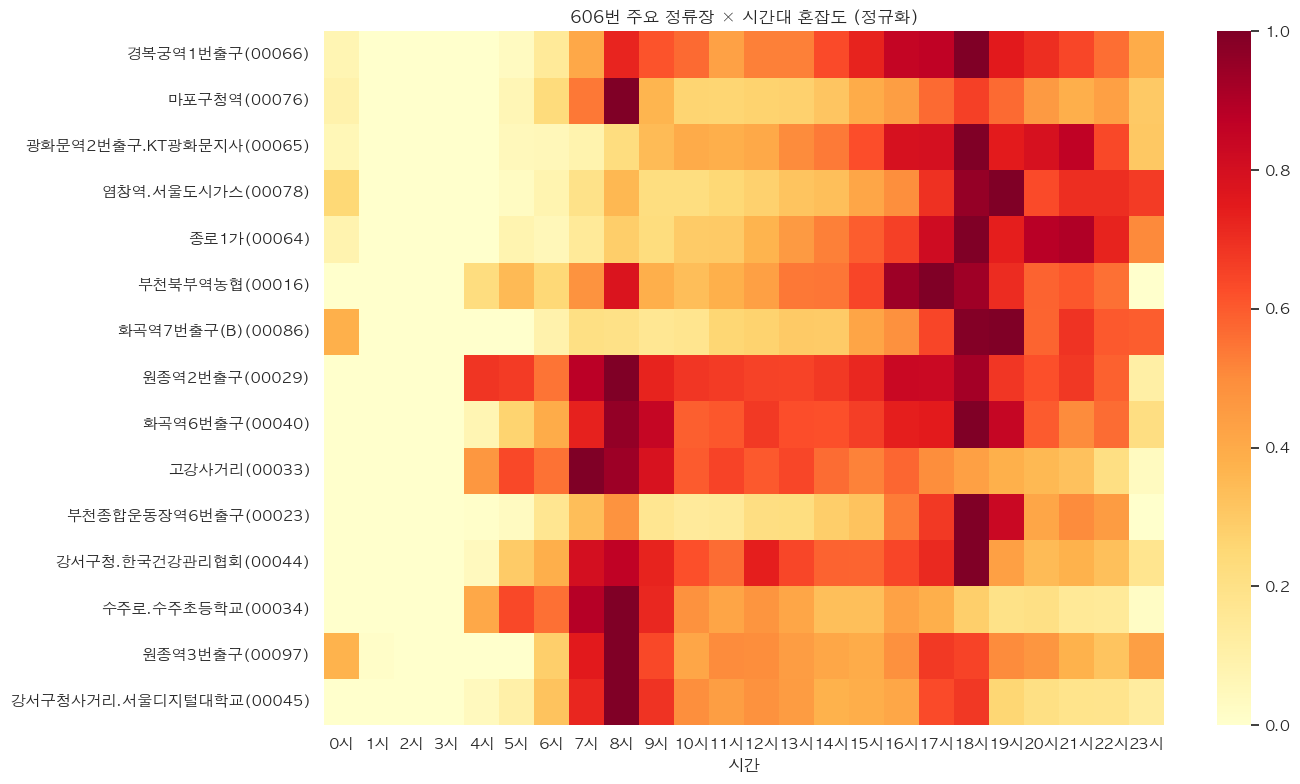

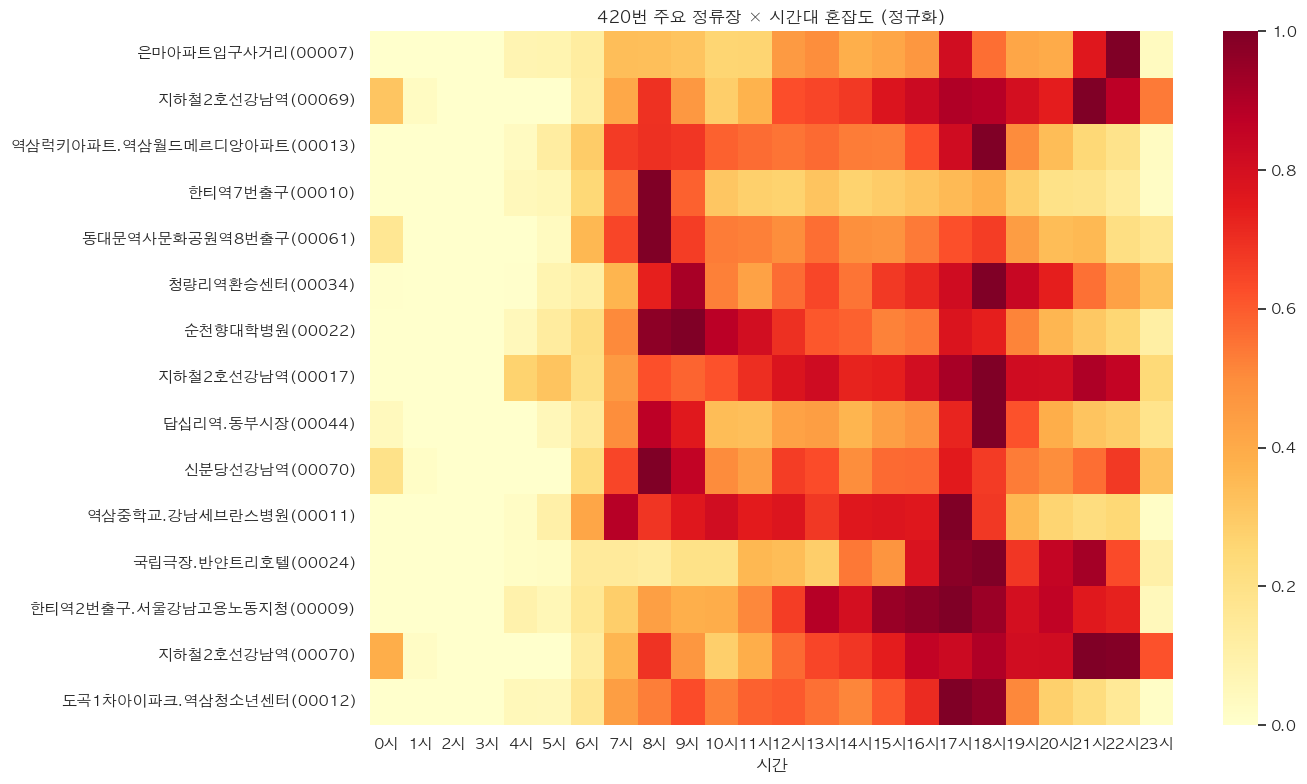

In [62]:
# 정류장별 시간대 혼잡도 (전체 기간 합산 후 max 기준 정규화)
for name, df in [('606', hourly_606), ('420', hourly_420)]:
    stop_hourly = df.groupby(['역명', '시간'])['승차'].sum().unstack(fill_value=0)
    # 정류장별 max로 정규화
    stop_hourly_norm = stop_hourly.div(stop_hourly.max(axis=1), axis=0)
    
    # 상위 15개 정류장
    top = stop_hourly.sum(axis=1).nlargest(15).index
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(stop_hourly_norm.loc[top], cmap='YlOrRd', vmin=0, vmax=1,
                xticklabels=[f'{h}시' for h in range(24)])
    plt.title(f'{name}번 주요 정류장 × 시간대 혼잡도 (정규화)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

## 9. 분석 결과 정리 및 추가 데이터 필요성 검토

### 현재 데이터로 도출 가능한 것

| 분석 항목 | 가능 여부 | 방법 |
|-----------|-----------|------|
| 평일 vs 주말 혼잡도 | ✅ 가능 | `사용일자` → 요일 추출 |
| 공휴일 효과 | ✅ 가능 | `holidays.csv` 매칭 |
| 요일별 패턴 | ✅ 가능 | 일별 데이터에서 요일 추출 |
| 월별 추세 | ✅ 가능 | 일별 데이터에서 월 추출 |
| 시간대별 피크 패턴 | ⚠️ 부분적 | 월별 집계 데이터 → **개별 날짜의 시간대 불가** |
| 날씨 영향 | ✅ 가능 | 날씨 데이터 병합 |
| 혼잡도 지수 (0~1) | ✅ 가능 | 승차인원 / 정류장별 max |

### 추가 데이터 필요성

| 데이터 | 필요도 | 이유 |
|--------|--------|------|
| **개별 날짜 × 시간대 승하차** | ⭐⭐⭐ 높음 | 현재 시간대 데이터가 월별 집계라 평일/주말 피크 구분 불가 |
| **평균 배차 대수** | ⭐⭐ 중간 | 승차인원을 차량 수로 나눠야 "차량당 혼잡도" 산출 가능 |
| **차량당 정원** | ⭐ 낮음 | 저상버스 정원은 대체로 동일(약 70명), 상수 처리 가능 |

### 핵심 결론

1. **평일/주말/공휴일 구분은 날짜만으로 충분히 가능**하다.
2. **출퇴근 피크타임 분석**은 현재 월별 집계 데이터에서 전체적인 패턴은 보이지만, **"월요일 8시 vs 토요일 8시"** 같은 세밀한 비교는 불가하다.
3. **차량 대수/차량당 인원** 없이도, 정류장별 max 기준 정규화(0~1)로 혼잡도 지수를 산출할 수 있다.  
   다만 이는 "해당 정류장의 과거 대비 상대적 혼잡"을 의미하며, 절대적 차량 내 혼잡도와는 다르다.
4. 모델 성능을 높이려면 **개별 날짜 × 시간대** 데이터를 추가 수집하는 것이 가장 효과적이다.

In [63]:
# 최종 피처 후보 정리
print("=== ML 모델 입력 피처 후보 ===")
print()
features = [
    ("날짜 기반", ["hour (0-23)", "day_of_week (0-6)", "month", "is_weekend", "is_holiday"]),
    ("피크타임", ["is_am_rush (7-9시)", "is_pm_rush (18-20시)"]),
    ("날씨", ["temperature", "precipitation", "wind_speed"]),
    ("정류장", ["stop_id", "stop_sequence (노선 내 순서)"]),
    ("이력", ["rolling_avg_1h", "rolling_avg_1d", "rolling_avg_1w"]),
]

for category, feats in features:
    print(f"[{category}]")
    for f in feats:
        print(f"  - {f}")
    print()

=== ML 모델 입력 피처 후보 ===

[날짜 기반]
  - hour (0-23)
  - day_of_week (0-6)
  - month
  - is_weekend
  - is_holiday

[피크타임]
  - is_am_rush (7-9시)
  - is_pm_rush (18-20시)

[날씨]
  - temperature
  - precipitation
  - wind_speed

[정류장]
  - stop_id
  - stop_sequence (노선 내 순서)

[이력]
  - rolling_avg_1h
  - rolling_avg_1d
  - rolling_avg_1w

